## Install Libraries

In [1]:
! pip install cython
! pip install git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI&egg=pycocotools
! pip install git+https://github.com/cocodataset/panopticapi.git#egg=panopticapi
! pip install scipy
! pip installonnx
! pip installonnxruntime

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-2cpz06dt
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-2cpz06dt
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp311-cp311-linux_x86_64.whl size=399200 sha256=4e94b50564a94b2b0b35ac7a68c8583860fc4fe8d014e1c2a365e05c2d6881ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-55ly70wx/wheels/6d/69/75/358c50a37672dfda8d74ba3b30ec49fb75d52f7c081886d503
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.8
    Uninstalling pycocotools-2.0.8:
      Successfully uninstalled pycocotools-2.0.8
  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-install-ho4wnv3q/panopticapi_69ea6ac9bb7444e1aa1256b50fb7857a
  Running com

## Decompress Data and Code

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/content/detr.zip -d /content/
!unzip /content/drive/MyDrive/content/license-plate-detection-datasets.zip -d /content/
%cd detr

Archive:  /content/drive/MyDrive/content/detr.zip
   creating: /content/detr/
   creating: /content/detr/.github/
  inflating: /content/detr/.github/CODE_OF_CONDUCT.md  
  inflating: /content/detr/.github/CONTRIBUTING.md  
  inflating: /content/detr/.github/DETR.png  
   creating: /content/detr/.github/ISSUE_TEMPLATE/
  inflating: /content/detr/.github/ISSUE_TEMPLATE/bugs.md  
  inflating: /content/detr/.github/ISSUE_TEMPLATE/questions-help-support.md  
  inflating: /content/detr/.github/ISSUE_TEMPLATE/unexpected-problems-bugs.md  
  inflating: /content/detr/.gitignore  
   creating: /content/detr/datasets/
  inflating: /content/detr/datasets/coco.py  
  inflating: /content/detr/datasets/coco_eval.py  
  inflating: /content/detr/datasets/coco_panoptic.py  
  inflating: /content/detr/datasets/panoptic_eval.py  
  inflating: /content/detr/datasets/transforms.py  
  inflating: /content/detr/datasets/__init__.py  
   creating: /content/detr/datasets/__pycache__/
  inflating: /content/detr/

## Starting Training

We will start training via torchrun for distributed training.

```bash
torchrun --nnodes=${NUM_MACHINES} --nproc-per-node=${NUM_GPUS_PER_MACHINE} \
    main.py --device cuda \
    --num_classes 1 \
    --dataset_file character \
    --coco_path ${DATA_DIR} \
    --backbone resnet50 \
    --output_dir ckpts/detr-lp-r50 \
    --batch_size 2 \
    --num_queries 10

```

DATA_DIR: Define the path to the dataset folder.

NUM_MACHINES: Number of machines you are using to train your model.

NUM_GPUS_PER_MACHINE: Number of GPUs per machine you are using to train your model.

num_queries: Number of queries in the Transformer (should be higher than maximum number of bounding boxes per image).

In [15]:
# Start Training

! torchrun --nnodes=1 --nproc-per-node=1 \
    main.py --device cuda \
    --num_classes 1 \
    --dataset_file character \
    --coco_path /content/license-plate-detection-datasets/ \
    --backbone resnet50 \
    --output_dir ckpts/detr-lp-r50 \
    --batch_size 2 \
    --num_queries 10 \
    --epochs 210 \
    --resume /content/drive/MyDrive/content/checkpoint0199.pth

| distributed init (rank 0): env://
[rank0]:[W303 01:31:35.276244562 ProcessGroupNCCL.cpp:4115] [PG ID 0 PG GUID 0 Rank 0]  using GPU 0 to perform barrier as devices used by this process are currently unknown. This can potentially cause a hang if this rank to GPU mapping is incorrect.Specify device_ids in barrier() to force use of a particular device,or call init_process_group() with a device_id.
fatal: not a git repository (or any of the parent directories): .git
git:
  sha: N/A, status: clean, branch: N/A

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=210, lr_drop=200, clip_max_norm=0.1, num_classes=1, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=10, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_co

## Inference

In [16]:
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image

from dataclasses import dataclass
from models import build_model
from models.backbone import Backbone, Joiner
from models.detr import DETR, PostProcess
from models.transformer import Transformer
from models.position_encoding import PositionEmbeddingSine

## Define Model Arguments

In [18]:
@dataclass
class Arguments:
    device: str = 'cuda:0'
    num_classes: int = 1
    backbone: str = "resnet50"
    hidden_dim: int = 256
    dropout: float = 0.1
    nheads: int = 8
    dim_feedforward: int = 2048
    enc_layers: int = 6
    dec_layers: int = 6
    pre_norm: bool = False
    num_queries: int = 10

## Load Detection Model

In [19]:
args = Arguments()

N_steps = args.hidden_dim // 2

position_embedding = PositionEmbeddingSine(N_steps, normalize=True)
backbone_ = Backbone(args.backbone, False, False, False)
backbone = Joiner(backbone_, position_embedding)
backbone.num_channels = backbone_.num_channels
transformer = Transformer(
        d_model=args.hidden_dim,
        dropout=args.dropout,
        nhead=args.nheads,
        dim_feedforward=args.dim_feedforward,
        num_encoder_layers=args.enc_layers,
        num_decoder_layers=args.dec_layers,
        normalize_before=args.pre_norm,
        return_intermediate_dec=True,
    )

model = DETR(
        backbone,
        transformer,
        num_classes=args.num_classes,
        num_queries=args.num_queries,
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Define Inerence Image Transformation

In [20]:
# standard PyTorch mean-std input image normalization
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(800),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

## Define Functions for Detection and Visualization

In [21]:
def detect(im, model, transform, threshold=0.7):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with threshold+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'license-plate: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

## Load Model From Checkpoint

In [22]:
ckpt_path = "/content/detr/ckpts/detr-lp-r50/checkpoint.pth"
checkpoint = torch.load(ckpt_path, map_location="cpu")
msg = model.load_state_dict(checkpoint['model'])
print(f"Loaded Model From {ckpt_path}: {msg}")

<ipython-input-22-e4297bb4ecb6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location="cpu")


Loaded Model From /content/detr/ckpts/detr-lp-r50/checkpoint.pth: <All keys matched successfully>


## Perform Detection

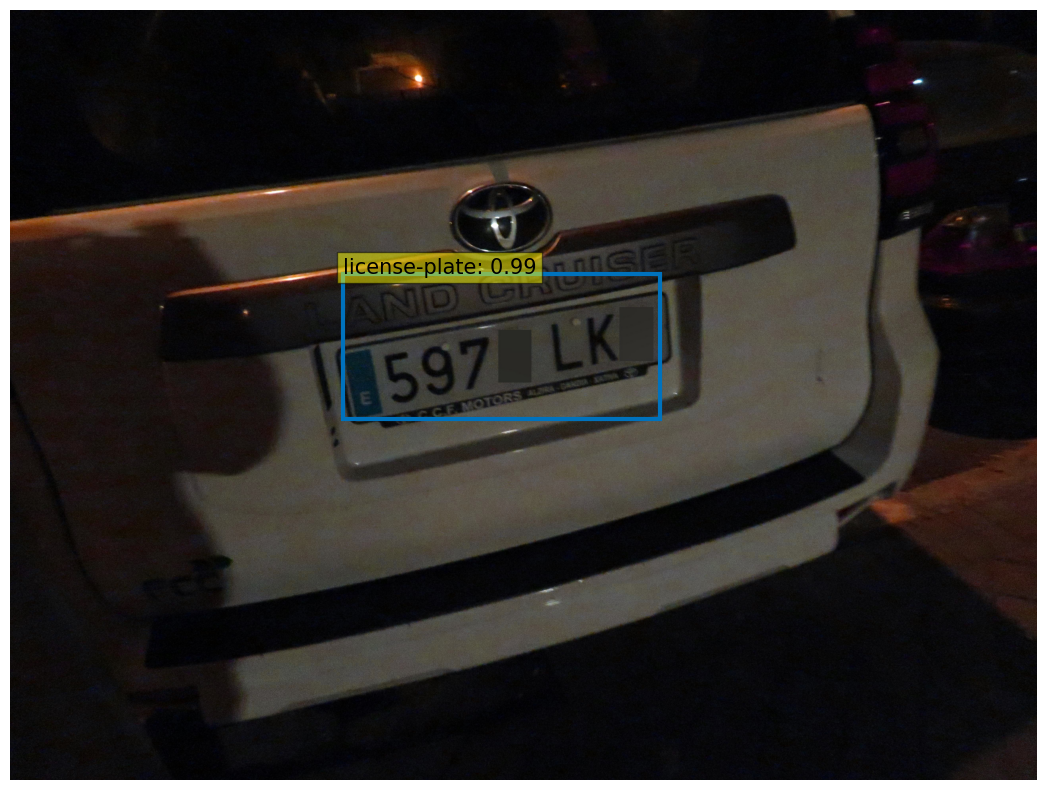

In [23]:
image_path = "/content/license-plate-detection-datasets/data/00000.jpg"
image = Image.open(image_path)
scores, boxes = detect(image, model, transform, threshold=0.9)
plot_results(image, scores, boxes)